In [23]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import sys
import tables.group


import macd
import pandas.io.data as web
import matplotlib.pyplot as plt
import multiprocessing as mp
%matplotlib inline
filename='source/depth8.hd5'
path='data/depth8_r.hd5'
print pd.__version__

0.17.1


In [33]:

h5 = pd.HDFStore(filename, 'r')
    
def getGroups(h5):
    groups = {}
    for i in h5.items():
        groups[i[0]]=(i[0],i[1])
    return groups

def getTables(group):
    group=group[1]
    tables={}
    for c in group._v_children:
        tables[c]=group._f_get_child(c)
    return tables

def getIndex(group):
    return getTables(group)['axis1'][:]

def getColumns(group):
    return getTables(group)['axis0'][:]

def getColumn(group,name):
    columns = getColumns(group)
    cidx=0
    while cidx<len(columns) and columns[cidx] != name:
        cidx+=1 
        
    if cidx >= len(columns):
        return None
    
    return getTables(group)['block0_values'][:][:]

def dedupIdx(idx):
    if len(idx) <=0:
        return idx

    idx=idx*1000
    p=idx[0]
    c=0
    for i in range(1,len(idx)):
        idxo=idx[i]
        if idx[i]==p:
            idx[i]+=c
            c+=1
        else:
            c=1
        p=idxo
    return idx
        
def getDataFrame(group):
    idx = getIndex(group)
    idx=pd.to_datetime(idx,unit='s')
    #idx=dedupIdx(idx)
    columns = getColumns(group)
    tables= getTables(group)['block0_values']
    dt = pd.DataFrame(tables[:][:],columns=columns,index=idx)
    return dt

def getDataFrames(h5):
    groups =  getGroups(h5)

    keys = sorted(groups.keys())
    dfs={}
    for k in keys:
        df = getDataFrame(groups[k])
        dfs[k]=df
    return dfs
        



        

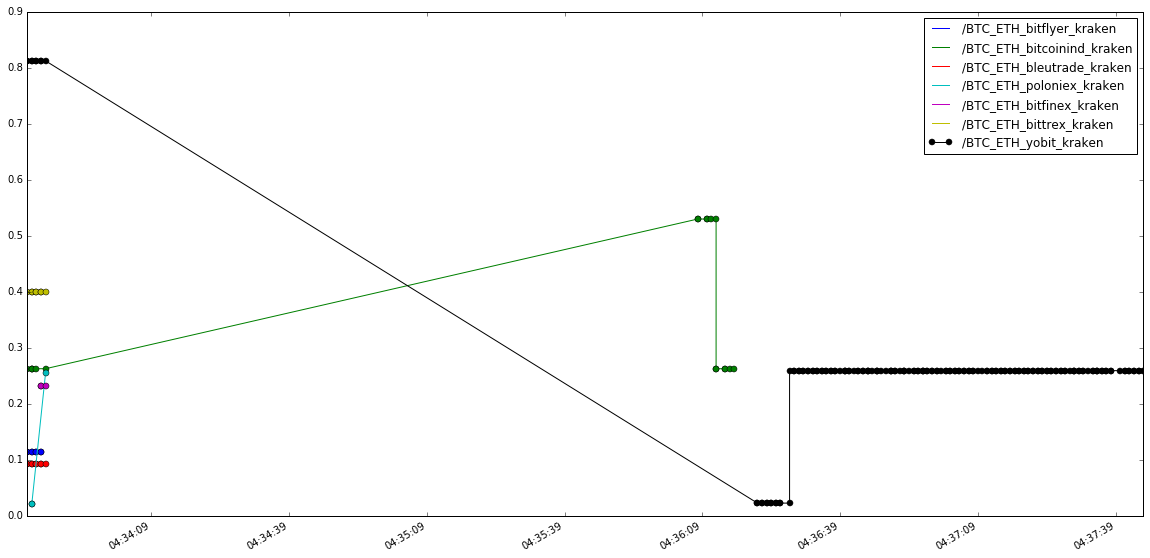

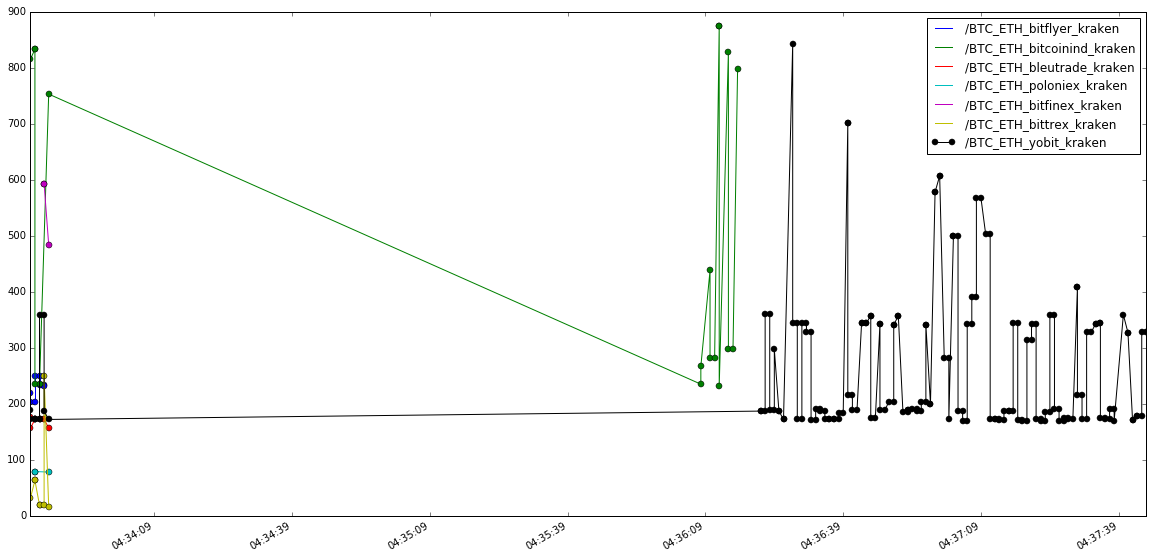

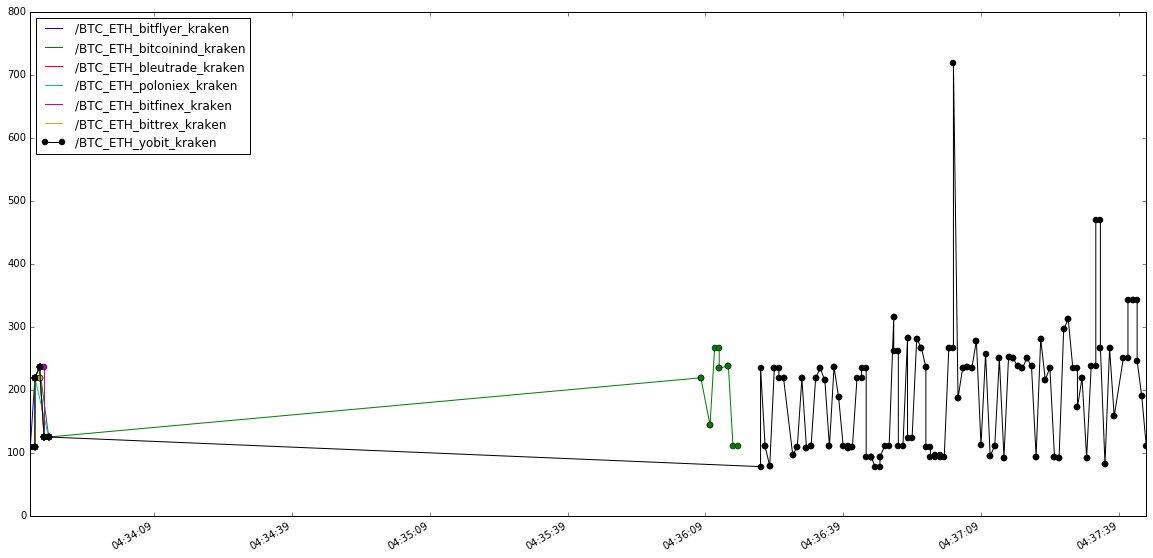

In [82]:
figsize=(20, 10)


def plotPair(pair='/BTC_ETH',exchanges=[],dtFrom=None,dtTo=None):
    #from :'2016-05-14 02:00:00'
    #to '2016-05-14 02:12:00'
    dfs=getDataFrames(h5)
    fig, axs1 = plt.subplots(1,1,figsize=figsize)
    fig, axs2 = plt.subplots(1,1,figsize=figsize)
    fig, axs3 = plt.subplots(1,1,figsize=figsize)
    for n in dfs.keys():
        if not n.startswith(pair):
            continue
        f=[e for e in exchanges if n.find(e)!=-1]
        if len(exchanges)!=0 and len(f)==0:
            continue
        df=dfs[n]
        btc=df['profitBtc'].loc[dtFrom:dtTo]
        rt1=df['rt1'].loc[dtFrom:dtTo]
        rt2=df['rt2'].loc[dtFrom:dtTo]
        

        
        if len(btc) > 0:
            btc.plot(ax=axs1,figsize=figsize,label=n,legend=True,marker='o')
            rt1.plot(ax=axs2,figsize=figsize,label=n,legend=True,marker='o')
            rt2.plot(ax=axs3,figsize=figsize,label=n,legend=True,marker='o')

plotPair(exchanges=['kraken'],dtFrom='2016-05-14 04:20:25')

In [32]:
print pd.to_datetime(dfs['/BTC_ETH_yobit_poloniex'].index,unit='s')

DatetimeIndex(['2016-05-14 02:20:25', '2016-05-14 02:20:25',
               '2016-05-14 02:20:25', '2016-05-14 02:20:26',
               '2016-05-14 02:20:26', '2016-05-14 02:20:27',
               '2016-05-14 02:20:27', '2016-05-14 02:20:28',
               '2016-05-14 02:20:28', '2016-05-14 02:20:29',
               ...
               '2016-05-14 04:37:40', '2016-05-14 04:37:41',
               '2016-05-14 04:37:41', '2016-05-14 04:37:42',
               '2016-05-14 04:37:42', '2016-05-14 04:37:43',
               '2016-05-14 04:37:43', '2016-05-14 04:37:44',
               '2016-05-14 04:37:44', '2016-05-14 04:37:45'],
              dtype='datetime64[ns]', length=295, freq=None)
